In [1]:
import blocksci

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import collections
import random

In [4]:
import datetime

In [5]:
import utils

In [6]:
chain = blocksci.Blockchain(utils.blocksci_config())

In [7]:
my_cm = blocksci.cluster.ClusterManager(utils.latest_clustering(), chain)

In [8]:
%time standard_count = chain.blocks.map(lambda b: b.txes.where(lambda tx: blocksci.heuristics.is_standard_tx(tx)).size)

CPU times: user 1min 6s, sys: 14.8 s, total: 1min 21s
Wall time: 3min 22s


In [9]:
%time all_count = chain.blocks.map(lambda b: b.tx_count)

CPU times: user 385 ms, sys: 5.29 ms, total: 391 ms
Wall time: 390 ms


In [10]:
%time block_heights = chain.blocks.height

CPU times: user 381 ms, sys: 5.34 ms, total: 387 ms
Wall time: 386 ms


In [11]:
%time block_times = chain.blocks.time

CPU times: user 365 ms, sys: 2.27 ms, total: 367 ms
Wall time: 366 ms


In [12]:
df_all = pd.DataFrame({"all": all_count, "standard": standard_count}, index = block_times)

In [13]:
df_all = df_all.resample("1 M").sum()

In [14]:
full_gt = blocksci.GroundTruth(utils.latest_groundtruth(), chain)

In [15]:
%time gt_counts = full_gt.transactions().group_by(lambda tx: tx.block.height, lambda txes: txes.size)

CPU times: user 5.93 s, sys: 1.42 s, total: 7.36 s
Wall time: 7.33 s


In [16]:
gtheight, gtcount = list(map(list, zip(*gt_counts.items())))

In [17]:
df_gt = pd.DataFrame({"gt": gtcount}, index=gtheight)

In [18]:
df_gt = df_gt.sort_index()

In [19]:
df_gt = df_gt.merge(pd.DataFrame(index=block_heights), how="outer", left_index=True, right_index=True)

In [20]:
df_gt = df_gt.fillna(0)

In [21]:
df_gt.index = block_times

In [22]:
df_gt = df_gt.resample("1 M").sum()

In [23]:
df_merged = df_all.merge(df_gt, how="outer", left_index=True, right_index=True)

In [24]:
df_merged["Share of all transactions"] = df_merged["gt"] / df_merged["all"]

In [25]:
df_merged["Share of standard transactions"] = df_merged["gt"] / df_merged["standard"]

In [26]:
df_merged = df_merged.drop(columns=["all", "standard", "gt"])

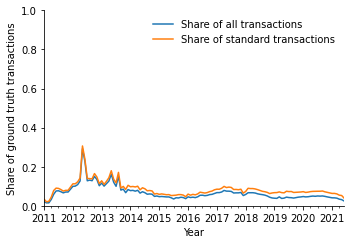

In [27]:
ax = df_merged.plot(xlim=(datetime.datetime(2011, 1, 1)), ylim=(0,1), xlabel="Year", ylabel="Share of ground truth transactions", figsize=(5, 3.5))
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
ax.get_figure().savefig("figures/gt-share-of-tx.pdf", format="pdf")

In [28]:
df_gt["gt"].sum() / df_all["standard"].sum() * 100

7.559995951268948

In [29]:
df_gt["gt"].sum() / df_all["all"].sum() * 100

5.402458796064023

In [30]:
df_merged["Share of standard transactions"].mean()

0.07542459347767777

In [31]:
df_merged["Share of all transactions"].mean()

0.056558447061445305

In [34]:
monthly_standard = df_gt["gt"].resample("1 M").sum() / df_all["standard"].resample("1 M").sum()

In [35]:
np.mean(monthly_standard)

0.07542459347767777

In [36]:
# skewed by early months
np.std(monthly_standard)

0.04443318576865876